In [6]:
from transformers import AutoProcessor, AutoModelForImageTextToText,AutoModelForCausalLM,AutoTokenizer
from transformers.image_utils import load_image
from transformers import AutoTokenizer
from PIL import Image
import torch

In [7]:
import json

In [50]:
# Load model and processor
model_id_vlm = "LiquidAI/LFM2-VL-450M"
model_vlm = AutoModelForImageTextToText.from_pretrained(
    model_id_vlm,
    device_map={"": "cpu"},  # force CPU
    torch_dtype="float32",   # safer on CPU
    trust_remote_code=True
)
processor_vlm = AutoProcessor.from_pretrained(model_id_vlm, trust_remote_code=True)

# ===== LOAD TEST IMAGE =====
# image_path = "./detected/003843_detections.jpg"
image_path = "data/final-horizontal.jpg"
image = Image.open(image_path)
if image.mode != "RGB":
    image = image.convert("RGB")

# image = image.resize((256, 256), Image.LANCZOS)
image = image.resize((512, 512), Image.LANCZOS)
# image = image.resize((384, 680), Image.LANCZOS)
# image = image.resize((1000, 3000), Image.LANCZOS)


# Load model and processor
model_id_llm = "LiquidAI/LFM2-350M"
model_llm = AutoModelForCausalLM.from_pretrained(
    model_id_llm,
    device_map="auto",
    torch_dtype="bfloat16",
    trust_remote_code=True
)
tokenizer_vlm = AutoTokenizer.from_pretrained(model_id_llm)

conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {
                "type": "text",
                "text": """You are an expert gauge inspector. Carefully analyze the image of the gauge and do the following:
1. Identify the type of gauges (e.g., thermometer, pressure gauge, etc.).
2. Provide the current meter readings shown by the needle.
3. State the unit of measurements.
4. Present the final readings clearly in the format: "<value> <unit>".
Only provide the direct reading, no extra explanation."""
            },
        ],
    },
]


# Generate Answer
inputs = processor_vlm.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True,
    tokenize=True,
).to(model_vlm.device)


outputs = model_vlm.generate(**inputs, max_new_tokens=512)
decoded = processor_vlm.batch_decode(outputs, skip_special_tokens=True)[0]

# Extract only the assistant's reply
if "assistant" in decoded:
    response = decoded.split("assistant", 1)[1].strip()
else:
    response = decoded.strip()

print("\n--- Model Response ---")
print(response)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]


--- Model Response ---
123.56 <bar> 45.56 <C> 107.56 <mm>


In [88]:
# response = "<98.36 mm> <mm>"

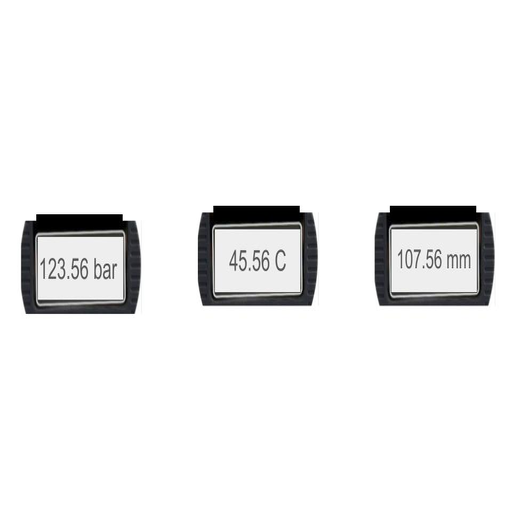

In [47]:
image

In [ ]:
# Example response
# response = "123.56 <bar> 45.56 <C> 107.56 <mm>"

In [10]:
import sqlite3
from datetime import datetime

# Parse only the numeric values (every 2nd element in the split list)
parts = response.split()
pressure = float(parts[0])     # 123.56
temperature = float(parts[2])  # 45.56
length = float(parts[4])       # 107.56

# Current timestamp (e.g., "2025-09-14 22:10:35")
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Connect to (or create) a SQLite DB
conn = sqlite3.connect("sensors.db")
cursor = conn.cursor()

# Create table if not exists (with timestamp column)
cursor.execute("""
CREATE TABLE IF NOT EXISTS sensor_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    timestamp TEXT,
    pressure REAL,
    temperature REAL,
    length REAL
)
""")

# Insert the parsed values with timestamp
cursor.execute("""
INSERT INTO sensor_data (timestamp, pressure, temperature, length)
VALUES (?, ?, ?, ?)
""", (timestamp, pressure, temperature, length))

# Commit and close
conn.commit()
conn.close()

In [11]:
import sqlite3

# Connect to the same database
conn = sqlite3.connect("sensors.db")
cursor = conn.cursor()

# Query all rows
cursor.execute("SELECT * FROM sensor_data")
rows = cursor.fetchall()

# Print nicely
for row in rows:
    print(row)

conn.close()


(1, '2025-09-14 08:48:05', 123.56, 45.56, 107.56)
(2, '2025-09-14 08:48:53', 123.56, 45.56, 107.56)
(3, '2025-09-14 08:48:55', 123.56, 45.56, 107.56)


In [12]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect("sensors.db")

# Load the whole table into a DataFrame
df = pd.read_sql_query("SELECT * FROM sensor_data", conn)

# Close the connection
conn.close()

# Display the DataFrame
print(df)


   id            timestamp  pressure  temperature  length
0   1  2025-09-14 08:48:05    123.56        45.56  107.56
1   2  2025-09-14 08:48:53    123.56        45.56  107.56
2   3  2025-09-14 08:48:55    123.56        45.56  107.56


/Users/george/.matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /var/folders/bw/zwn916250j389j86x0z9f6tr0000gn/T/matplotlib-sejm3o9m because there was an issue with the default path (/Users/george/.matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possib

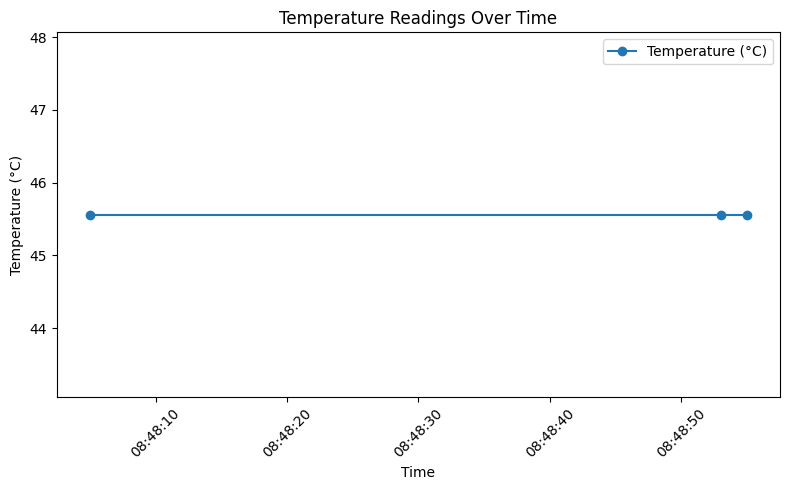

In [13]:
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime

# Connect to DB
conn = sqlite3.connect("sensors.db")
cursor = conn.cursor()

# Fetch timestamps and temperatures
cursor.execute("SELECT timestamp, temperature FROM sensor_data ORDER BY id ASC")
rows = cursor.fetchall()
conn.close()

# Separate into lists
timestamps = [datetime.strptime(r[0], "%Y-%m-%d %H:%M:%S") for r in rows]
temperatures = [r[1] for r in rows]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(timestamps, temperatures, marker="o", linestyle="-", label="Temperature (°C)")

plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Readings Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


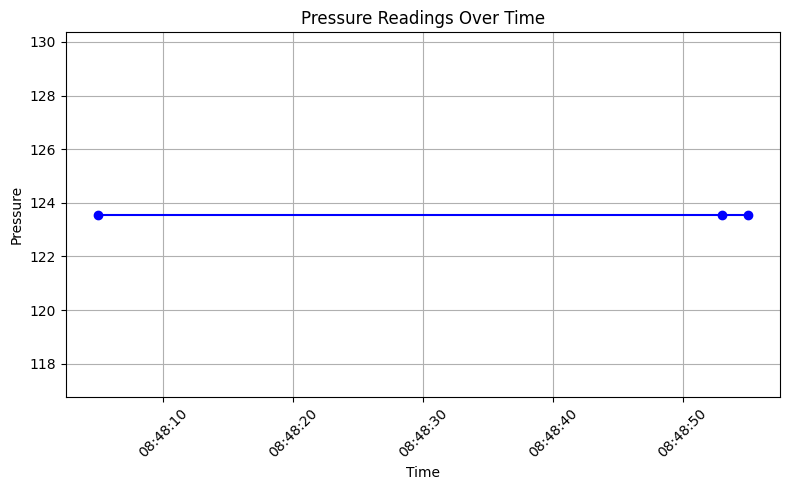

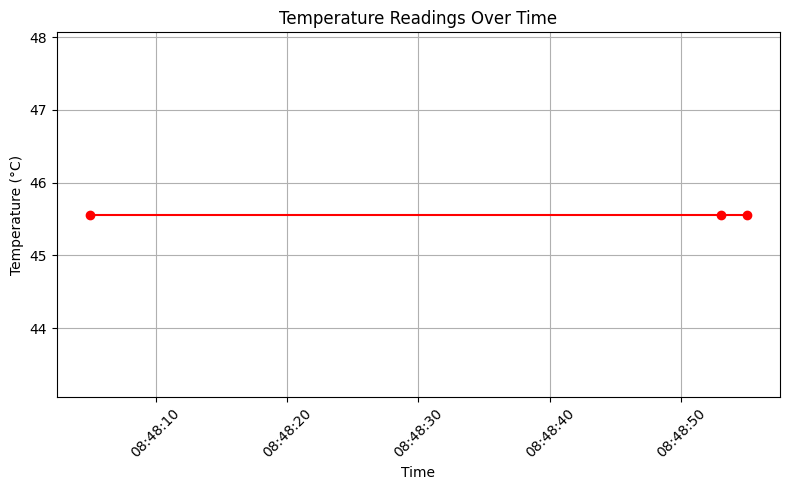

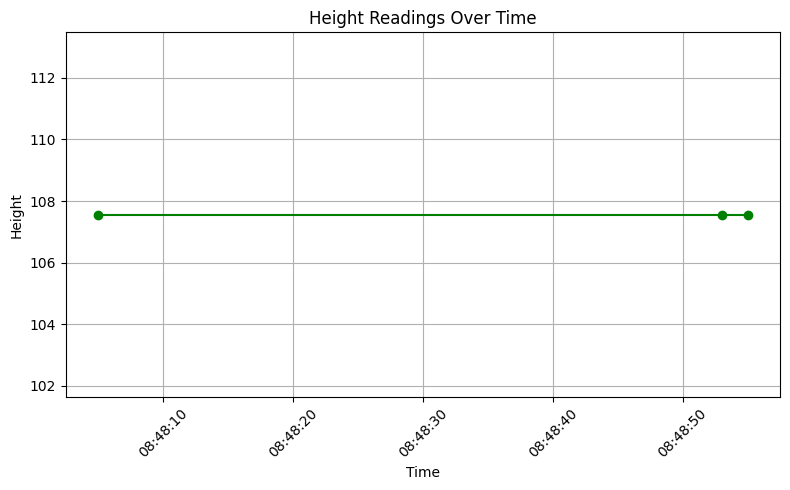

In [18]:
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime

# Connect to DB
conn = sqlite3.connect("sensors.db")
cursor = conn.cursor()

# Fetch all sensor data (timestamp, pressure, temperature, length/height)
cursor.execute("""
    SELECT timestamp, pressure, temperature, length FROM sensor_data ORDER BY id ASC
""")
rows = cursor.fetchall()
conn.close()

# Separate into lists
timestamps = [datetime.strptime(r[0], "%Y-%m-%d %H:%M:%S") for r in rows]
pressures = [r[1] for r in rows]
temperatures = [r[2] for r in rows]
heights = [r[3] for r in rows]

# Plot Pressure
plt.figure(figsize=(8, 5))
plt.plot(timestamps, pressures, marker="o", linestyle="-", color="blue", label="Pressure")
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.title("Pressure Readings Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Temperature
plt.figure(figsize=(8, 5))
plt.plot(timestamps, temperatures, marker="o", linestyle="-", color="red", label="Temperature (°C)")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Readings Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Height
plt.figure(figsize=(8, 5))
plt.plot(timestamps, heights, marker="o", linestyle="-", color="green", label="Height")
plt.xlabel("Time")
plt.ylabel("Height")
plt.title("Height Readings Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime

DB_PATH = "sensors.db"

def fetch_data():
    """Fetch all timestamps and temperature values from DB."""
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    cursor.execute("SELECT timestamp, temperature FROM sensor_data ORDER BY id ASC")
    rows = cursor.fetchall()
    conn.close()
    return rows

def animate(frame):
    rows = fetch_data()
    if not rows:
        return
    
    # Extract data
    timestamps = [datetime.strptime(r[0], "%Y-%m-%d %H:%M:%S") for r in rows]
    temperatures = [r[1] for r in rows]

    # Clear old plot
    plt.cla()
    plt.plot(timestamps, temperatures, marker="o", linestyle="-", label="Temperature (°C)")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.title("Live Temperature Readings")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

# Setup figure
fig = plt.figure(figsize=(8, 5))

# Run animation (update every 2 seconds)
ani = animation.FuncAnimation(fig, animate, interval=2000)

plt.show()

/var/folders/bw/zwn916250j389j86x0z9f6tr0000gn/T/ipykernel_60001/3171332155.py:40: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(fig, animate, interval=2000)


<Figure size 800x500 with 0 Axes>

In [74]:
def turn_on_light(room: str):
    return {"status": f"Light in {room} turned ON"}

def turn_off_light(room: str):
    return {"status": f"Light in {room} turned OFF"}

In [75]:
# Map function names to actual implementations
TOOLS = {
    "turn_on_light": turn_on_light,
    "turn_off_light": turn_off_light
}

In [76]:
# --------------------------
# Define tools JSON for LFM2
# --------------------------
tools_json = [
    {
        "name": "turn_on_light",
        "description": "Turn on the light in a specified room",
        "parameters": {
            "type": "object",
            "properties": {
                "room": {"type": "string", "description": "Name of the room"}
            },
            "required": ["room"]
        }
    },
    {
        "name": "turn_off_light",
        "description": "Turn off the light in a specified room",
        "parameters": {
            "type": "object",
            "properties": {
                "room": {"type": "string", "description": "Name of the room"}
            },
            "required": ["room"]
        }
    }
]

In [20]:
response

'123.56 <bar> 45.56 <C> 107.56 <mm>'

In [37]:
response = 'pressure: 123.56bar,  temperature: 45.56 C,  height: 107.56 mm'

In [38]:
meter_reading = response

In [39]:
meter_reading

'pressure: 123.56bar,  temperature: 45.56 C,  height: 107.56 mm'

In [31]:
# prompt = f"""
# <|startoftext|><|im_start|>system
# List of tools: <|tool_list_start|>{json.dumps(tools_json)}<|tool_list_end|><|im_end|>
# <|im_start|>user
# The meter reading is {meter_reading} mm.
# If the reading is greater than 80 mm, call turn_off_light with room="living_room".
# If it is 80 or less, do nothing.
# <|im_end|>
# <|im_start|>assistant
# """

In [32]:
# prompt = f"""
# <|startoftext|><|im_start|>system
# You are a controller that must decide whether to call a tool.
# Always respond ONLY with a valid tool call in JSON format.
# Do not explain or add text.

# List of tools: <|tool_list_start|>{json.dumps(tools_json)}<|tool_list_end|><|im_end|>

# <|im_start|>user
# The meter reading is {meter_reading} mm.
# If the reading is greater than 80 mm, call turn_off_light with room="living_room".
# If it is 80 or less, output {{}} to indicate no action.
# <|im_end|>
# <|im_start|>assistant
# """


In [33]:
# prompt = f"""
# <|startoftext|><|im_start|>system
# You are a controller that must decide whether to call a tool.
# Always respond ONLY with a JSON object matching this schema:

# {{
#   "name": "<tool_name>",
#   "arguments": {{ "room": "<room_name>" }}
# }}

# - If no tool is needed, respond with: {{}}
# - Do not explain or add text.
# <|im_end|>

# <|im_start|>user
# The meter reading is {meter_reading} mm.
# If the reading is greater than 80 mm, call turn_off_light with room="living_room".
# If it is 80 or less, output {{}}.
# <|im_end|>
# <|im_start|>assistant
# """


In [34]:
prompt = f"""
<|startoftext|><|im_start|>system
You are a controller that must decide whether to call a tool.
Always respond ONLY with a JSON object in this exact format:

{{"name": "turn_off_light", "arguments": {{"room": "living_room"}}}}

OR, if no action is needed:

{{}}

Nothing else is allowed. No quotes around keys unless shown. No extra fields. No explanation.
<|im_end|>

<|im_start|>user
The meter reading is {meter_reading} mm.
If the reading is greater than 80 mm, respond with the turn_off_light call.
If it is 80 or less, respond with {{}}.
<|im_end|>
<|im_start|>assistant
"""


In [35]:
# Load model and tokenizer
model_id = "LiquidAI/LFM2-350M"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map={"": "cpu"},  # force CPU
    torch_dtype="float32",   # safer on CPU
)
tokenizer_llm = AutoTokenizer.from_pretrained(model_id)

# Generate answer
# prompt = "What is the reading ? " + prompt 
input_ids = tokenizer_llm.apply_chat_template(
    [{"role": "user", "content": prompt}],
    add_generation_prompt=True,
    return_tensors="pt",
    tokenize=True,
).to(model.device)

output = model.generate(
    input_ids,
    do_sample=True,
    temperature=0.3,
    min_p=0.15,
    repetition_penalty=1.05,
    max_new_tokens=512,
)

print(tokenizer_llm.decode(output[0], skip_special_tokens=False))

<|startoftext|><|im_start|>user

<|startoftext|><|im_start|>system
You are a controller that must decide whether to call a tool.
Always respond ONLY with a JSON object in this exact format:

{"name": "turn_off_light", "arguments": {"room": "living_room"}}

OR, if no action is needed:

{}

Nothing else is allowed. No quotes around keys unless shown. No extra fields. No explanation.
<|im_end|>

<|im_start|>user
The meter reading is 123.56bar,  45.56 C,  107.56 mm mm.
If the reading is greater than 80 mm, respond with the turn_off_light call.
If it is 80 or less, respond with {}.
<|im_end|>
<|im_start|>assistant
<|im_end|>
<|im_start|>assistant
{turn_off_light: false}<|im_end|>


In [36]:
decoded_llm = tokenizer_llm.decode(output[0], skip_special_tokens=True)
print("\n--- LLM Decision ---")
print(decoded_llm)

# ----------------------------
# Step 5: Execute function if needed
# ----------------------------
if "turn_off_light" in decoded_llm:
    result = turn_off_light("living_room")
    print("\n--- Action Taken ---")
    print(result)
else:
    print("\n--- Action Taken ---\nNo action (reading safe).")


--- LLM Decision ---
user

system
You are a controller that must decide whether to call a tool.
Always respond ONLY with a JSON object in this exact format:

{"name": "turn_off_light", "arguments": {"room": "living_room"}}

OR, if no action is needed:

{}

Nothing else is allowed. No quotes around keys unless shown. No extra fields. No explanation.


user
The meter reading is 123.56bar,  45.56 C,  107.56 mm mm.
If the reading is greater than 80 mm, respond with the turn_off_light call.
If it is 80 or less, respond with {}.

assistant

assistant
{turn_off_light: false}


NameError: name 'turn_off_light' is not defined

In [68]:
# import json

# try:
#     action = json.loads(decoded_llm.strip().split("assistant")[-1].strip())
#     if action and action.get("name") == "turn_off_light":
#         result = turn_off_light(action["arguments"]["room"])
#         print("\n--- Action Taken ---")
#         print(result)
#     else:
#         print("\n--- Action Taken ---\nNo action (reading safe).")
# except json.JSONDecodeError:
#     print("\n--- Error ---\nInvalid LLM output:", decoded_llm)
